# Project Milestone 2 - Screen Science

This is a python notebook containing the main code for the Applied Data Analysis project. Please refer to the README.md for an overview of the project.

## Table of contents:
* [Imports](#minusoneth)
* [Data loading](#zeroeth)
* [Exploratory data analysis](#second)
    * [Duplicate data](#second_b)
    * [Missing data](#second_a)
* [Data preprocessing](#first)
* [Focus : Technology in real life](#third)
    * [Lost movies](#third_a)
    * [Silent films & black and white films](#third_b)
    * [Special effects](#third_c)
* [Focus : Technology in movies](#fourth)
    * [Movies about technology](#fourth_a)
        * [Science Fiction & Fantasy](#fourth_a1)
        * [Keyphrase analysis](#fourth_a2)
        * [Historical events](#fourth_a3)
    * [Sentiment analysis](#fourth_b)
* [Next steps](#fifth)


## Imports <a class="anchor" id="minusoneth"></a>

We list the packages used by the project.

* [pandas](https://pandas.pydata.org/) - data handling
* [numpy](https://numpy.org/) - array math
* [seaborn](https://seaborn.pydata.org/) - visualisation
* [matplotlib](https://matplotlib.org/) - visualisation

In [1]:
# Imports
import pandas as pd
import numpy as np
import scipy as scp
import seaborn as sns
import matplotlib as mat
import matplotlib.pyplot as plt
import IPython.display
from helpers import *
from scipy.stats import bootstrap

# Package versions on last run
print_versions([pd, np, sns, mat])

pandas==2.0.3
numpy==1.25.2
seaborn==0.12.2
matplotlib==3.7.2


## Data Loading <a class="anchor" id="zeroeth"></a>

We employ `load_data_with_columns` to read data from the following files as dataframes with named columns. 
* `character.metadata.tsv`
* `movie.metadata.tsv`
* `name.clusters.txt`
* `plot_summaries.txt`
* `tvtropes.clusters.txt`

The column names are listed in `column_names.txt`. Additionally, some date fields are immediately parsed with `date_to_int`.

In [2]:
# Loading the data
DATAFOLDER = '../data/'

# Character metadata
character_metadata = load_data_with_columns(DATAFOLDER, 'character.metadata.tsv')
character_metadata = parse_as_year(character_metadata, 'movie_release_date')

# Movie metadata
movie_metadata = load_data_with_columns(DATAFOLDER, 'movie.metadata.tsv')
movie_metadata = parse_as_year(movie_metadata, 'movie_release_date')

# Plot summaries
plot_summaries = load_data_with_columns(DATAFOLDER, 'plot_summaries.txt')

## Exploratory data analysis <a class="anchor" id="second"></a>

We go ahead and look at the data, at first the number of entries, and we see that it is manageable.

In [3]:
# Display character metadata
display(character_metadata)
print("Number of entries: ", np.prod(character_metadata.shape))

,movie_wikipedia_id,movie_freebase_id,movie_release_date,character_name,actor_birth_date,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_map_id,character_freebase_id,actor_freebase_id
0,975900,/m/03vyhn,2001-01-01,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-01-01,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-01-01,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-01-01,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-01-01,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-01-01,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv
450665,913762,/m/03pcrp,1992-01-01,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j
450666,28308153,/m/0cp05t9,1957-01-01,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44
450667,28308153,/m/0cp05t9,1957-01-01,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm


Number of entries:  5858697


In [4]:
# Display movie metadata
display(movie_metadata)
print("Number of entries: ", np.prod(movie_metadata.shape))

,movie_wikipedia_id,movie_freebase_id,movie_name,movie_release_date,box_office,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-01-01,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-01-01,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,[German Language],[Germany],[Drama]
...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-01-01,NaN,120.0,[English Language],[United States of America],[Drama]
81737,34980460,/m/0g4pl34,Knuckle,2011-01-01,NaN,96.0,[English Language],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]"
81738,9971909,/m/02pygw1,Another Nice Mess,1972-01-01,NaN,66.0,[English Language],[United States of America],"[Satire, Comedy]"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-01-01,NaN,150.0,[Japanese Language],[Japan],"[Science Fiction, Japanese Movies, Adventure, ..."


Number of entries:  735669


In [5]:
# Display plot summaries
display(plot_summaries)
print("Number of entries: ", np.prod(plot_summaries.shape))

,movie_wikipedia_id,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...
...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho..."
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look..."
42300,35102018,American Luthier focuses on Randy Parsons’ tra...
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se..."


Number of entries:  84606


**Initial remarks**
1. There appear to be more rows in movie_metadata than in plot_summaries. This can be due to duplicate or missing data. 

### Duplicate data <a class="anchor" id="second_b"></a>

We show the following: 
1. The wikipedia IDs are unique in `movie_metadata` and `plot_summaries`.
2. There are different movies with exactly the same plot summary text, due to different film industries or remakes of the same movie.

In [6]:
# The wikipedia_id's are unique in both tables.
assert(movie_metadata['movie_wikipedia_id'].is_unique)
assert(plot_summaries['movie_wikipedia_id'].is_unique)

# Summaries with no metadata
movie_metadata_ids = movie_metadata['movie_wikipedia_id'].to_list()
plot_summaries_ids = plot_summaries['movie_wikipedia_id'].to_list()
plot_no_metadata = [id for id in plot_summaries_ids if id not in movie_metadata_ids]

In [7]:
# Duplicate plot texts
duplicated_plots = plot_summaries[plot_summaries['plot'].duplicated(keep=False)]
print("There are {:d} plot summaries that appear more than once.".format(len(duplicated_plots['plot'].unique())))

There are 5 plot summaries that appear more than once.


In [8]:
# Left-merge movie metadata with plots. This disregards the 99 plots with no metadata
movies_with_plots = movie_metadata.merge(plot_summaries, how='left')

# There are movies with different titles but identical plots.
movies_with_plots.set_index('movie_wikipedia_id').loc[duplicated_plots['movie_wikipedia_id']].groupby('plot')['movie_name'].unique().reset_index()

,plot,movie_name
0,A woman is thrown out of her home by her jealo...,"[Madame X, The Trial of Madame X]"
1,An orphan Raghav turns into a ruthless contrac...,"[Antham, Drohi]"
2,"As the American Civil War begins, Ned Burton l...",[The Warrens of Virginia]
3,Raja was adopted by a criminal don at a very ...,[Amar Deep]
4,Taking a step aside from the usual serious dra...,"[Andhamaina Anubhavam, Ninaithale Inikkum]"


What can we know about these movies whose plots appear multiple times?

In [9]:
# Print data about those movies who share a plot with another movie.
movie_metadata[movie_metadata['movie_wikipedia_id'].isin(duplicated_plots['movie_wikipedia_id'])][['movie_name', 'movie_release_date', 'languages', 'countries']].sort_values(by='movie_name')

,movie_name,movie_release_date,languages,countries
22185,Amar Deep,1979-01-01,[Hindi Language],[India]
32255,Amar Deep,NaT,[Hindi Language],[]
59148,Andhamaina Anubhavam,1979-01-01,[Telugu language],[India]
67464,Antham,1992-01-01,[Telugu language],[India]
28621,Drohi,1992-01-01,[Hindi Language],[India]
18993,Madame X,1916-01-01,"[Silent film, English Language]",[United States of America]
49381,Madame X,1920-01-01,"[Silent film, English Language]",[United States of America]
57569,Madame X,1954-01-01,[Greek Language],[Greece]
65014,Madame X,1981-01-01,[English Language],[United States of America]
59142,Ninaithale Inikkum,1979-01-01,[Tamil Language],[India]


**We note the following**:
1. *Andhamaina Anubhavam* / *Ninaithale Inikkum* are the Telugu and Tamil names for the same movie. 
2. *Antham* / *Drohi* are the Telugu and Hindi names for the same movie.
3. There are multiple movie adaptations of the play *(The Trial of) Madame X*. 
4. There is a "lost" 1924 version of the movie The Warrens of Virginia, with the same plot, but it appears in this dataset.
5. The movie *Amar Deep* appearing twice appears to simply be a dataset error.

### Plot summaries word-count

We show that the word-counts follows a negative exponential distribution (y axis is in logarithmic scale). Most films have a short summary: most of them have a word-count below 500 words. In fact, nearly half of the dataset lies in the 100 to 500 words range. A very low percentage of films have a summary above 1000. Thus there might be a disparity in the precision of the plot due to the difference in length. Thus, longer plot summaries have higher chances of including multiple and more precise tech-related or event-related keywords.

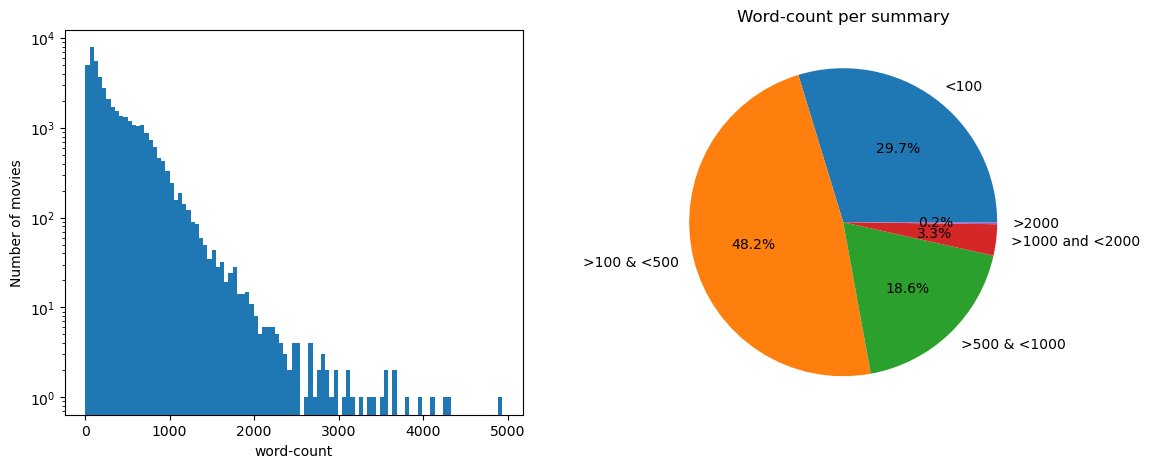

In [32]:
def length_plot(plot):
    punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''

    for char in punc:
        if np.isin(char, plot):
            plot.replace(char, '')
    
    split = plot.split()
    return len(split)

plot_summaries['word_count'] = plot_summaries['plot'].apply(length_plot)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (13, 5))
ax2.pie([plot_summaries[plot_summaries['word_count'] <= 100].shape[0], plot_summaries[(plot_summaries['word_count'] > 100)&(plot_summaries['word_count'] <= 500)].shape[0], plot_summaries[(plot_summaries['word_count'] > 500)&(plot_summaries['word_count'] <= 1000)].shape[0],
          plot_summaries[(plot_summaries['word_count'] > 1000)&(plot_summaries['word_count'] <= 2000)].shape[0], plot_summaries[plot_summaries['word_count'] > 2000].shape[0]],
          labels = ['<100', '>100 & <500', '>500 & <1000', '>1000 and <2000', '>2000'], autopct='%1.1f%%')
ax1.hist(plot_summaries['word_count'], bins= round(plot_summaries['word_count'].max()/50))
ax1.set_yscale('log')
ax1.set_ylabel('Number of movies')
ax1.set_xlabel('word-count')
plt.title('Word-count per summary')
plt.show()

### Missing data <a class="anchor" id="second_a"></a>

We show the following:
1. The wikipedia IDs in `plot_summaries` are not a subset of those in `movie_metadata`, as there are 99 summaries with no associated metadata. 
2. The percentage of missing plot summaries per decade **decreases**, while the absolute number of missing plot summaries **increases**.

In [11]:
# Number of summaries with no metadata.
print("There are {:d} plot summaries with no associated metadata".format(len(plot_no_metadata)))
plot_summaries.set_index('movie_wikipedia_id').loc[plot_no_metadata].reset_index()

There are 99 plot summaries with no associated metadata


,movie_wikipedia_id,plot,word_count
0,2862137,Sathyanarayan Murthy is a rough but kind man ...,105
1,33334420,{{more plot}} Mural tells the story of Zhu Xia...,53
2,16758721,"The story is about a young man “Tony”, a 25 ye...",128
3,23217064,"Years before the events of the first film, Lo...",657
4,2746943,"A young 16-year-old girl, Zhu Ying Tai, manage...",475
...,...,...,...
94,35607003,Parisian Marion is living in New York with her...,21
95,32942181,"Rajat , Nishant ""Liquid"" Agarwal and Vikrant ...",365
96,133671,Gerry Conlon is shown in Belfast stripping le...,402
97,34076714,"After a hit gone wrong, Nikita, an exiled Russ...",94


What is the percentage of missing plot summary data per decade?

In [12]:
# Bin movies into decades
movies_with_decades = bin_into_decades(movies_with_plots, 'movie_release_date').copy()

# Bootstrap parameters
bootstrap_args = {'statistic' : percent_nans, 'n_resamples':100, 'confidence_level':0.95, 'alternative':'two-sided', 'method':'percentile'}

# Groupby decades
plots_by_decade = movies_with_decades.groupby('decade', observed=False, group_keys=True)['plot']

# Perform bootstrap estimation of missing plot summary data
intervals_by_decade = plots_by_decade.apply(lambda x: bootstrap((duplicate_singleton(x), ), **bootstrap_args).confidence_interval[:])

# Unpack intervals into dataframe
low_high_by_decade = expand_list_data(pd.DataFrame(intervals_by_decade).set_axis(['interval'],axis=1), 'interval', ['low', 'high']).copy()

# Put data together
missing_plots = pd.concat([pd.DataFrame({
    'mean':plots_by_decade.apply(percent_nans), 
    'count':plots_by_decade.apply(lambda x: x.isnull().sum())}), 
    low_high_by_decade], axis=1)

In [13]:
movies_with_plots

,movie_wikipedia_id,movie_freebase_id,movie_name,movie_release_date,box_office,runtime,languages,countries,genres,plot
0,975900,/m/03vyhn,Ghosts of Mars,2001-01-01,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-01-01,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",NaN
2,28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",NaN
3,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...
4,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,[German Language],[Germany],[Drama],"Eva, an upper class housewife, becomes frustra..."
...,...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-01-01,NaN,120.0,[English Language],[United States of America],[Drama],Two former National Oceanic Atmospheric Admini...
81737,34980460,/m/0g4pl34,Knuckle,2011-01-01,NaN,96.0,[English Language],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]",{{No plot}} This film follows 12 years in the ...
81738,9971909,/m/02pygw1,Another Nice Mess,1972-01-01,NaN,66.0,[English Language],[United States of America],"[Satire, Comedy]",NaN
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-01-01,NaN,150.0,[Japanese Language],[Japan],"[Science Fiction, Japanese Movies, Adventure, ...","The story takes place in the year 2092,The Sup..."


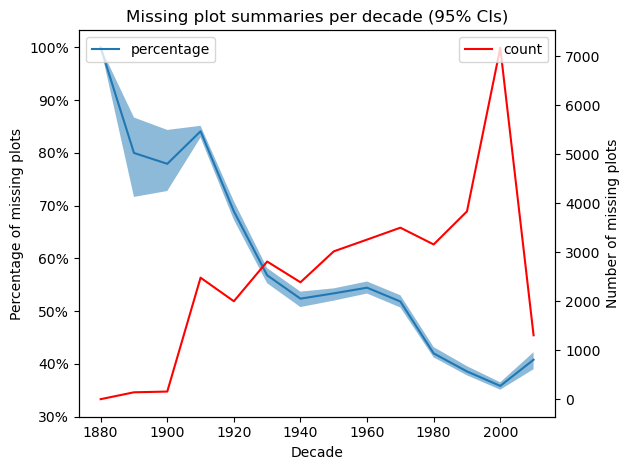

In [14]:
# Plot percentage and count
fig, ax1 = plt.subplots()
ax1.set_title(f"Missing plot summaries per decade (95% CIs)")
ax1.set_xlabel("Decade")
ax1.set_ylabel("Percentage of missing plots")
plot_with_confidence(missing_plots, 'mean', 'percentage', ax1)
ax1.set_yticks(ticks=ax1.get_yticks()[:-1], labels=["{:.0f}%".format(p*100) for p in ax1.get_yticks()[:-1]])
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel('Number of missing plots')
ax2.plot(missing_plots['count'], label = 'count', color='red')
ax2.legend(loc='upper right')
ax2.tick_params(axis='y')

fig.tight_layout()
plt.show()

## Data preprocessing  <a class="anchor" id="first"></a>

## Focus : Technology in real life <a class="anchor" id="third"></a>

### Lost movies <a class="anchor" id="third_a"></a>

### Silent & black and white films <a class="anchor" id="third_b"></a>

### Special effects <a class="anchor" id="third_c"></a>

## Focus : Technology in movies <a class="anchor" id="fourth"></a>

### Movies about technology <a class="anchor" id="fourth_a"></a>

#### Science fiction & fantasy <a class="anchor" id="fourth_a1"></a>

#### Keyphrase analysis <a class="anchor" id="fourth_a2"></a>

#### Historical events <a class="anchor" id="fourth_a3"></a>

### Sentiment analysis <a class="anchor" id="fourth_b"></a>

## Next steps <a class="anchor" id="fifth"></a>

(Todo)